Import Libraries

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor



In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import shap



Load Enhanced Dataset

In [14]:
df = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_test.csv')

In [15]:
# Drop unnecessary columns
X = df.drop(columns=['Unnamed: 0', 'Item_Outlet_Sales', 'Log_Sales', 'Item_Identifier'])
y = df['Log_Sales']


Recursive Feature Elimination

###### Idea is to find out the set of features that yield best scores and then those features can be used for training.

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Optimal number of features: 3
Selected Features:
['Item_MRP', 'Sales_to_MRP', 'MRP_Deviation_From_Tier_Median']


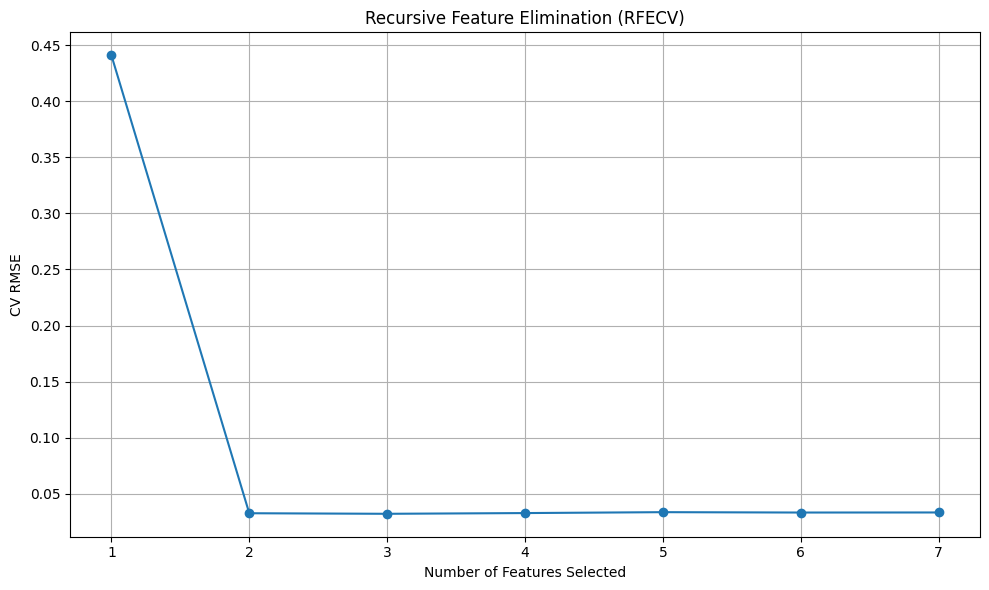

In [16]:
# Base model
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)


cv = KFold(n_splits=5, shuffle=True, random_state=42)

# RFECV for automatic feature pruning
rfecv = RFECV(
    estimator=xgb,
    step=1,                   # removing 1 feature at a time
    cv=cv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit RFE on training set
rfecv.fit(X, y)

# Show results
print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected Features:")
selected_features = X.columns[rfecv.support_]
print(selected_features.tolist())


plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    -rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("CV RMSE")
plt.title("Recursive Feature Elimination (RFECV)")
plt.grid()
plt.tight_layout()
plt.show()


KFold Cross Validation

In [17]:

# Load data
df = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_test.csv')

# Drop unnecessary columns
X = df.drop(columns=['Unnamed: 0', 'Item_Outlet_Sales', 'Log_Sales', 'Item_Identifier', 'Freq_Bin_Item_Cluster'])
y = df['Log_Sales']

# Initialize model configuration
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.7,
    'reg_lambda': 1.5,
    'n_jobs': -1,
    'random_state': 42
}

# KFold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_valid_preds_all = []
y_valid_true_all = []
test_preds_accumulator = np.zeros(len(df_test))

# Train and evaluate in KFold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_pred_log = model.predict(X_val)
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_true = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")

    y_valid_preds_all.extend(y_val_pred)
    y_valid_true_all.extend(y_val_true)

    # Predict test and accumulate
    X_test = df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier'], errors='ignore')
    X_test = X_test.reindex(columns=X.columns, fill_value=0)
    test_preds_log = model.predict(X_test)
    test_preds = np.expm1(test_preds_log)
    test_preds_accumulator += test_preds / kf.n_splits

# Overall CV RMSE
overall_rmse = np.sqrt(mean_squared_error(y_valid_true_all, y_valid_preds_all))
print(f"\nOverall CV RMSE: {overall_rmse:.4f}")

# Prepare submission
submission = pd.DataFrame()

# Load encoders
with open('/content/drive/MyDrive/ABB/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Restore labels
for col in ['Item_Identifier', 'Outlet_Identifier']:
    if col in df_test.columns and col in encoders:
        submission[col] = encoders[col].inverse_transform(df_test[col].astype(int))
    else:
        submission[col] = df_test[col]

submission['Item_Outlet_Sales'] = test_preds_accumulator
submission.to_csv('/content/drive/MyDrive/ABB/xgb_kfold_submission.csv', index=False)
print("\nSubmission file saved as: xgb_kfold_submission.csv")



--- Fold 1 ---
Fold 1 RMSE: 121.4921

--- Fold 2 ---
Fold 2 RMSE: 145.2875

--- Fold 3 ---
Fold 3 RMSE: 103.2796

--- Fold 4 ---
Fold 4 RMSE: 184.9709

--- Fold 5 ---
Fold 5 RMSE: 291.9232

Overall CV RMSE: 182.1745

Submission file saved as: xgb_kfold_submission.csv


KFold Stratified

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters Found: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.3, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


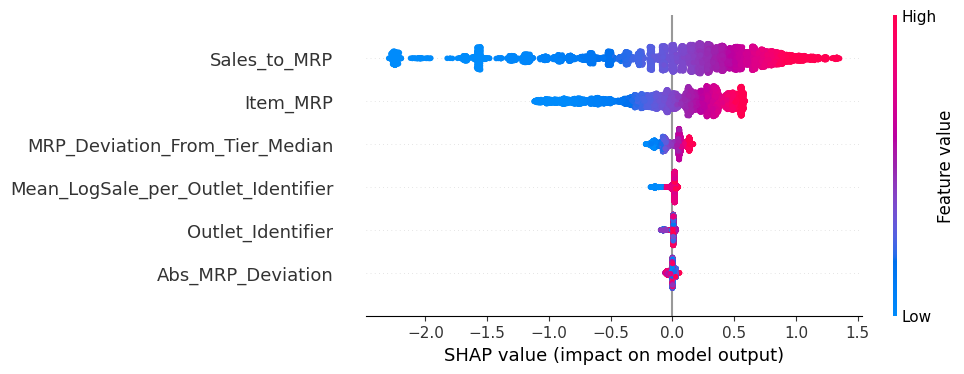

Submission file saved as: xgb_final_stratified_submission.csv


In [18]:
df = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ABB/data/enhanced_test.csv')

# Drop columns not needed for training
drop_cols = ['Unnamed: 0', 'Item_Outlet_Sales', 'Log_Sales', 'Item_Identifier','Freq_Bin_Item_Cluster']
X = df.drop(columns=drop_cols)
y = df['Log_Sales']

# Ensure stratify column is categorical
stratify_labels = df['Freq_Bin_Item_Cluster'].astype(str)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [4, 5, 6],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.3, 0.7],
    'reg_lambda': [0.5, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    scoring=rmse_scorer,
    n_iter=25,
    cv=skf.split(X, stratify_labels),
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

best_model = search.best_estimator_
print("Best Parameters Found:", search.best_params_)

best_model.fit(X, y)
explainer = shap.Explainer(best_model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=25)

# Align test set to train columns
X_test = df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier'], errors='ignore')
X_test = X_test.reindex(columns=X.columns, fill_value=0)

test_preds_log = best_model.predict(X_test)
test_preds = np.expm1(test_preds_log)

submission = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()

with open('/content/drive/MyDrive/ABB/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

for col in ['Item_Identifier', 'Outlet_Identifier']:
    if col in encoders:
        submission[col] = encoders[col].inverse_transform(df_test[col].astype(int))

submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('/content/drive/MyDrive/ABB/xgb_final_stratified_submission.csv', index=False)
print("Submission file saved as: xgb_final_stratified_submission.csv")
